In [1]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


### Inference with pre-trained RT-DETR model

#### Load model

In [2]:
# @title Load model

CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

In [3]:
# @title Run inference

# URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"
#
# image = Image.open(requests.get(URL, stream=True).raw)
image = Image.open(r"F:\DATASET\NACTI\images\nacti_part0\2010_Unit150_Ivan097_img0003.jpg")
inputs = processor(image, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)

w, h = image.size
results = processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.3)

Detected labels: ['sheep', 'cat']


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


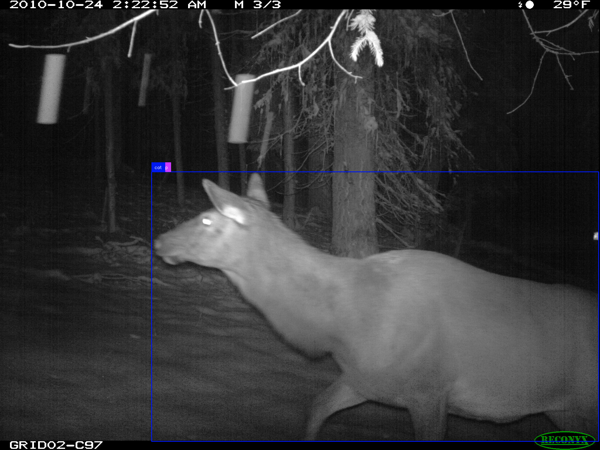

In [4]:
detections = sv.Detections.from_transformers(results[0])
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]
print(f"Detected labels: {labels}")

annotated_image = image.copy()
annotated_image = sv.BoundingBoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels=labels)
annotated_image.thumbnail((600, 600))
annotated_image

### Fine-tuning RT-DETR on custom data

In [5]:
from src.dataset import NACTIAnnotationDataset
from torch.utils.data import DataLoader

dataset = NACTIAnnotationDataset(
    image_dir=r"F:\DATASET\NACTI\images\nacti_part0",
    json_path=r"E:\result\json\detection\part0output.json",
    csv_path=r"F:\DATASET\NACTI\meta\nacti_metadata_part0.csv"
)

Image loaded: (2048, 1536), Target: {'boxes': tensor([[1822.,  785.,  223.,  385.]]), 'labels': tensor([0]), 'common_name': 'red deer'}
Image loaded: (2048, 1536), Target: {'boxes': tensor([[1060.,  675.,  982.,  826.]]), 'labels': tensor([0]), 'common_name': 'red deer'}
Image loaded: (2048, 1536), Target: {'boxes': tensor([[ 523.,  582., 1518.,  919.]]), 'labels': tensor([0]), 'common_name': 'red deer'}
Image loaded: (2048, 1536), Target: {'boxes': tensor([[   0.,  672., 1449.,  829.]]), 'labels': tensor([0]), 'common_name': 'red deer'}
Image loaded: (2048, 1536), Target: {'boxes': tensor([[  0., 656., 547., 847.]]), 'labels': tensor([0]), 'common_name': 'red deer'}


In [6]:
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None, None
    images, targets = zip(*batch)
    return list(images), list(targets)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate_fn
)

In [8]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=500)

In [ ]:
from tqdm import tqdm

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")

    for images, targets in loop:
        pixel_values = [processor(images=image, return_tensors="pt").pixel_values.squeeze(0) for image in images]
        pixel_values = torch.stack(pixel_values).to(DEVICE)

        labels = [{"boxes": t['boxes'].to(DEVICE), "class_labels": t['labels'].to(DEVICE)} for t in targets]

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        loop.set_postfix(loss=loss.item())

print("Training complete!")


Epoch 1/10


Training Epoch 1:   0%|          | 37/62500 [00:49<23:17:36,  1.34s/it, loss=1.43e+5]

In [ ]:
model.save_pretrained("./fine_tuned_rt_detr")
processor.save_pretrained("./fine_tuned_rt_detr")
print("Model saved successfully!")
